In [45]:
# Sentiment Analysis and Sentiment Modeling for Amazon Reviews

In [46]:
# Amazon üzerinden satışlarını gerçekleştiren ev tesktili ve günlük giyim odaklı üretimler yapan Kozmos ürünlerine
# gelen yorumları analiz ederek ve aldığı şikayetlere göre özelliklerini geliştirerek satışlarını artırmayı hedeflemektedir.
# Bu hedef doğrultusunda yorumlara duygu analizi yapılarak etiketlencek ve   etiketlenen veri ile sınıflandırma modeli
# oluşturulacaktır.

In [47]:
# Review: Ürüne yapılan yorum
# Title: Yorum içeriğine verilen başlık, kısa yorum
# HelpFul: Yorumu faydalı bulan kişi sayısı
# Star: Ürüne verilen yıldız sayısı


In [48]:

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.sentiment import SentimentIntensityAnalyzer
from warnings import filterwarnings

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.width', 200)

In [49]:
df = pd.read_excel("amazon.xlsx")
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5611 entries, 0 to 5610
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Star     5611 non-null   int64 
 1   HelpFul  5611 non-null   int64 
 2   Title    5559 non-null   object
 3   Review   5593 non-null   object
dtypes: int64(2), object(2)
memory usage: 175.5+ KB


In [51]:
# Normalizing Case Folding
df['Review'] = df['Review'].str.lower()
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,happy with it
1,5,0,Pattern did not align between the two panels.,good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,product was fun for bedroom windows.<br />imag...
3,5,0,Que se ven elegantes muy finas,lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,great bang for the buck i can't believe the qu...


In [52]:
# Punctuations
df['Review'] = df['Review'].str.replace('[^\w\s]', '')

In [53]:
# Numbers
df['Review'] = df['Review'].str.replace('\d', '')

In [54]:
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,happy with it
1,5,0,Pattern did not align between the two panels.,good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,product was fun for bedroom windows.<br />imag...
3,5,0,Que se ven elegantes muy finas,lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,great bang for the buck i can't believe the qu...


In [55]:
# Stopwords
import nltk
nltk.download('stopwords')
sw = stopwords.words('english')
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [58]:
sw #Stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [59]:
# Rarewords / Custom Words

sil = pd.Series(' '.join(df['Review']).split()).value_counts()[-1000:]
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in x.split() if x not in sil))

In [60]:
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,happy
1,5,0,Pattern did not align between the two panels.,good quality material however panels mis-matched.
2,5,0,Imagery is stretched. Still fun.,product fun bedroom windows.<br />imagery bit ...
3,5,0,Que se ven elegantes muy finas,lo unico que gustaria es que sean un poco mas ...
4,5,0,Wow great purchase,great bang buck can't believe quality material...


In [61]:
sil

,count
prettier!,1
"say,",1
out(which,1
extensions,1
"sturdy,",1
...,...
use..,1
sum,1
pic..,1
jus,1


In [62]:
# Lemmatization
import nltk # Make sure nltk is imported
nltk.download('wordnet') # Download the 'wordnet' corpus
df['Review'] = df['Review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

df['Review'].head(10)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Review
0,happy
1,good quality material however panel mis-matched.
2,product fun bedroom windows.<br />imagery bit ...
3,lo unico que gustaria e que sean un poco ma la...
4,great bang buck can't believe quality material...
5,look different photo
6,exactly looking for. heavy material. great pri...
7,"looking picture, thought curtain would thinner..."
8,much whiter thought would wasn’t really expect...
9,curtain picture shows. 3rd set ambesonne curta...


In [63]:
#     Görev 2: Metin Görselleştirme
##############################################################
# Barplot
        # a. "Review" değişkeninin içerdiği kelimeleri frekanslarını hesaplayınız, tf olarak kaydediniz
        # b. tf dataframe'inin sütunlarını yeniden adlandırınız: "words", "tf" şeklinde
        # c. "tf" değişkeninin değeri 500'den çok olanlara göre filtreleme işlemi yaparak barplot ile görselleştirme işlemini tamamlayınız.


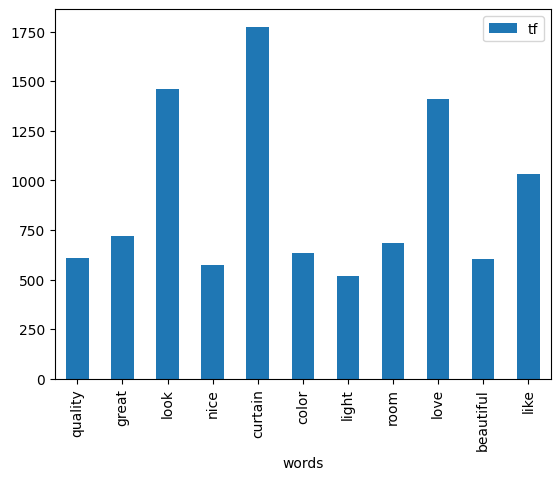

In [64]:
tf = df["Review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.columns = ["words", "tf"]
tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show()

In [65]:
# Wordcloud

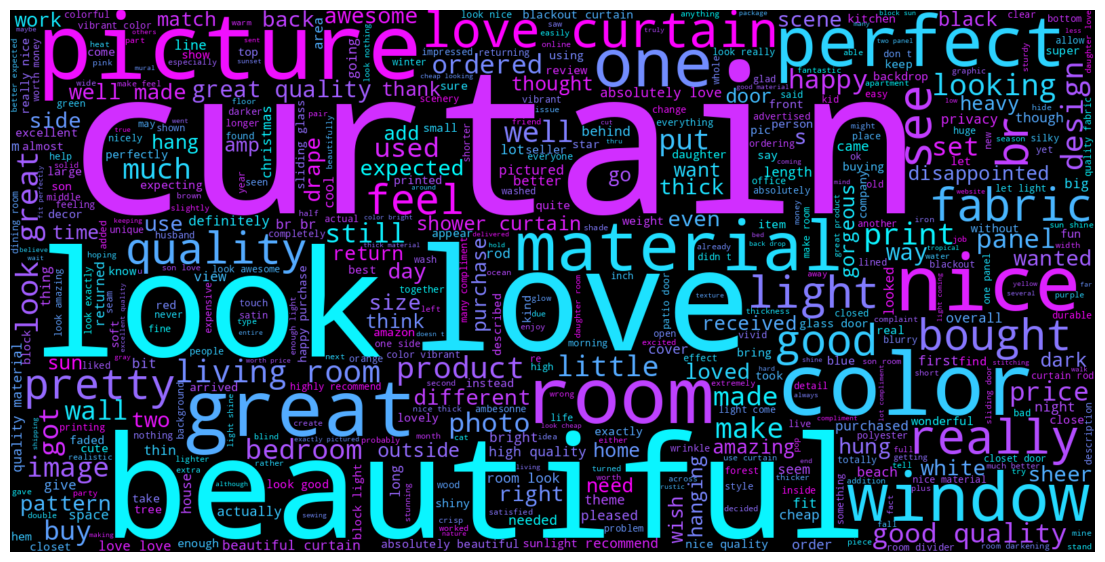

In [66]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Tüm yorumları birleştir
text = " ".join(i for i in df.Review)

# WordCloud oluştur
wordcloud = WordCloud(
    max_font_size=300,        # Maksimum yazı boyutunu artır
    max_words=500,            # Maksimum kelime sayısını belirle
    background_color="black", # Arka planı siyah yap
    colormap="cool",          # Kelimeleri mavi tonlarında yap
    width=1600,               # WordCloud genişliğini artır
    height=800                # WordCloud yüksekliğini artır
).generate(text)

# Görselleştirme
plt.figure(figsize=(14, 8))  # Daha büyük bir grafik boyutu
plt.imshow(wordcloud, interpolation="bilinear")  # Daha pürüzsüz bir geçiş
plt.axis("off")  # Eksenleri kaldır
plt.show()

In [67]:
# Görev 3: Duygu Analizi
##############################################################

import nltk

# Download the 'vader_lexicon' dataset
nltk.download('vader_lexicon')


from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [68]:
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x))


,Review
0,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound..."
1,"{'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'comp..."
2,"{'neg': 0.0, 'neu': 0.647, 'pos': 0.353, 'comp..."
3,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,"{'neg': 0.0, 'neu': 0.537, 'pos': 0.463, 'comp..."
5,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
6,"{'neg': 0.0, 'neu': 0.661, 'pos': 0.339, 'comp..."
7,"{'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'comp..."
8,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
9,"{'neg': 0.0, 'neu': 0.772, 'pos': 0.228, 'comp..."


In [69]:

df["Review"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])


,Review
0,0.57
1,0.44
2,0.72
3,0.00
4,0.90
5,0.00
6,0.62
7,0.93
8,0.00
9,0.71


In [70]:

df["Review"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")


,Review
0,pos
1,pos
2,pos
3,neg
4,pos
5,neg
6,pos
7,pos
8,neg
9,pos


In [71]:

df["Sentiment_Label"] = df["Review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")


In [72]:

df.groupby("Sentiment_Label")["Star"].mean()

# NOT:SentimentIntensityAnalyzer ile yorumları etiketleyerek, yorum sınıflandırma makine öğrenmesi modeli için bağımlı değişken oluşturulmuş oldu.



,Star
Sentiment_Label,
neg,3.47
pos,4.57


In [73]:
#Makine öğrenmesine hazırlık!
 #Makine öğrenmesi modeline verileri verebilmemiz için temsil şekillerini sayısala çevirmemiz gerekmekte.
           # a. TfidfVectorizer kullanarak bir nesne oluşturunuz.
           # b. Daha önce ayırmış olduğumuz train datamızı kullanarak oluşturduğumuz nesneye fit ediniz.
           # c. Oluşturmuş olduğumuz vektörü train ve test datalarına transform işlemini uygulayıp kaydediniz.

# Test-Train
train_x, test_x, train_y, test_y = train_test_split(df["Review"],
                                                    df["Sentiment_Label"],
                                                    random_state=42)


# TF-IDF Word Level
tf_idf_word_vectorizer = TfidfVectorizer().fit(train_x)
x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)


In [74]:
#Modelleme (Lojistik Regresyon)
###############################

log_model = LogisticRegression().fit(x_train_tf_idf_word, train_y)



In [42]:

y_pred = log_model.predict(x_test_tf_idf_word)

print(classification_report(y_pred, test_y))

cross_val_score(log_model, x_test_tf_idf_word, test_y, cv=5).mean()


              precision    recall  f1-score   support

         neg       0.32      0.97      0.48        73
         pos       1.00      0.89      0.94      1330

    accuracy                           0.89      1403
   macro avg       0.66      0.93      0.71      1403
weighted avg       0.96      0.89      0.91      1403



0.8538891713268937

In [43]:
random_review = pd.Series(df["Review"].sample(1).values)
yeni_yorum = CountVectorizer().fit(train_x).transform(random_review)
pred = log_model.predict(yeni_yorum)
print(f'Review:  {random_review[0]} \n Prediction: {pred}')


Review:  sort stain can’t explain see shade sun 
 Prediction: ['pos']


In [44]:
 #Modelleme (Random Forest)
###############################
#Lojistik regresyon modeli ile sonuçları karşılaştırınız.

rf_model = RandomForestClassifier().fit(x_train_tf_idf_word, train_y)
cross_val_score(rf_model, x_test_tf_idf_word, test_y, cv=5, n_jobs=-1).mean()


0.8973589222165735